# Customer Attrition - Data Exploration and Predictive Modeling

We will continue to explore our data and use machine learning to solve our problem in this notebook. Below, we import the necessary Python libraries, initialize the H2O library, and set the NumPy random seed so that our results will be deterministic.

In [1]:
%%capture

from h2o import init, H2OFrame, no_progress
from h2o.estimators import H2OGradientBoostingEstimator, H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.random.seed(21)
init()
no_progress()

Below, we read in the training and test sets we saved at the end of our previous notebook.

In [2]:
train = pd.read_csv('Datasets/train.csv', index_col = 0)
test = pd.read_csv('Datasets/test.csv', index_col = 0)

Before we use predictive modeling to identify customers in the target city that would be likely to quit the credit card services, we need to identify variables in our data that are dependent on other variables, either through correlation or direct relation. Such variables will not decrease the predictive power of our machine learning model, but they will mess with the interpretability of the model.

The credit limit of a customer's account is the maximum amount that can be spent on the customer's credit card without being paid off, and the revolving balance is the amount spent that has not been paid off. Meanwhile, the open-to-buy amount is the amount that can be spent without being paid off, and the utilization ratio is the proportion of allowable credit that has been used. Therefore, the average utilization ratio might be the ratio between the average revolving balance and the credit limit, and the average open to buy might be the difference between the credit limit and the average revolving balance. We verify these two ideas using the scatter plots below.

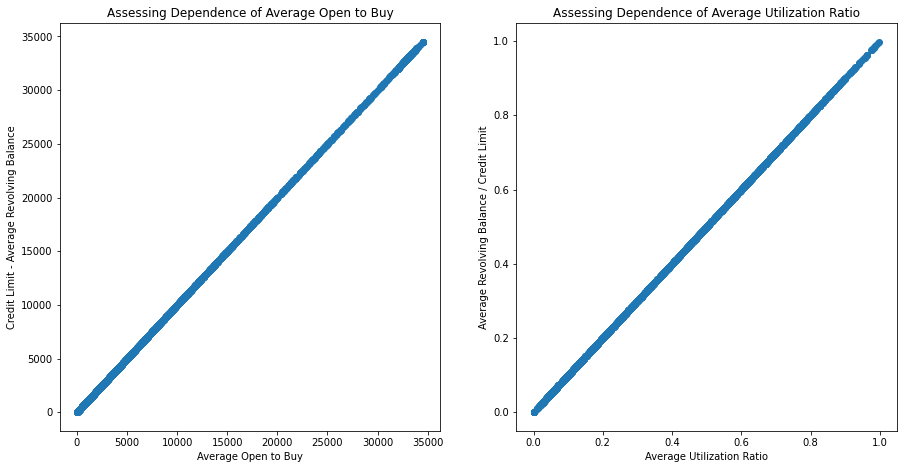

In [3]:
fig1 = plt.figure(figsize = (15, 7.5))
ax1_1 = fig1.add_subplot(1, 2, 1)
ax1_2 = fig1.add_subplot(1, 2, 2)

ax1_1.scatter(train['Avg_Open_To_Buy'], train['Credit_Limit'] - train['Avg_Revolving_Bal'])
ax1_1.set_xlabel('Average Open to Buy')
ax1_1.set_ylabel('Credit Limit - Average Revolving Balance')
ax1_1.set_title('Assessing Dependence of Average Open to Buy')

ax1_2.scatter(train['Avg_Utilization_Ratio'], train['Avg_Revolving_Bal'] / train['Credit_Limit'])
ax1_2.set_xlabel('Average Utilization Ratio')
ax1_2.set_ylabel('Average Revolving Balance / Credit Limit')
ax1_2.set_title('Assessing Dependence of Average Utilization Ratio')

plt.show(fig1)

It is clear from the two plots above that the average open to buy amount is equal to the credit limit minus the average revolving balance, and that the average utilization ratio is equal to the average revolving balance divided by the credit limit. Therefore, these two variables should be removed from the training and test sets.

Although the total number of transactions and the total dollar amount in transactions are not directly related, it is reasonable to assume that they would be positively correlated. Consequently, it is also reasonable to assume that the change in number of transactions would be positively correlated with the change in amount in transactions. We assess the strength of these correlations using the scatter plots below.

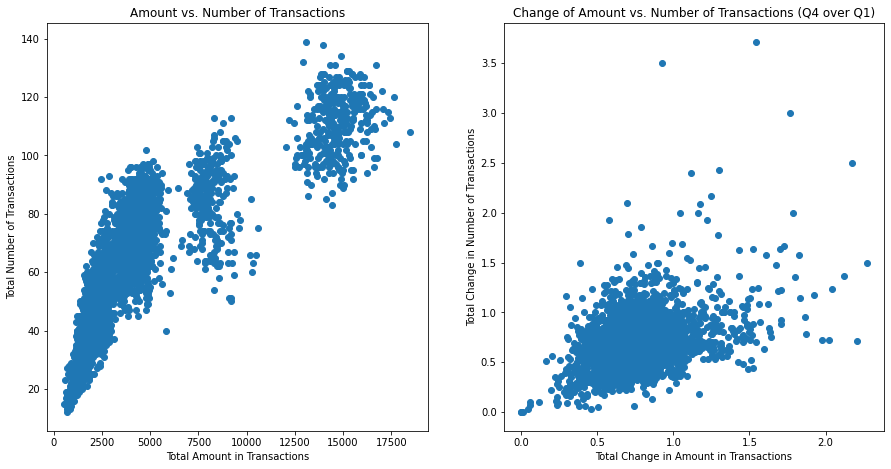

In [4]:
fig2 = plt.figure(figsize = (15, 7.5))
ax2_1 = fig2.add_subplot(1, 2, 1)
ax2_2 = fig2.add_subplot(1, 2, 2)

ax2_1.scatter(train['Total_Trans_Amt'], train['Total_Trans_Ct'])
ax2_1.set_xlabel('Total Amount in Transactions')
ax2_1.set_ylabel('Total Number of Transactions')
ax2_1.set_title('Amount vs. Number of Transactions')

ax2_2.scatter(train['Total_Amt_Chng_Q4_Q1'], train['Total_Ct_Chng_Q4_Q1'])
ax2_2.set_xlabel('Total Change in Amount in Transactions')
ax2_2.set_ylabel('Total Change in Number of Transactions')
ax2_2.set_title('Change of Amount vs. Number of Transactions (Q4 over Q1)')

plt.show(fig2)

The plots above show that the total number of transactions is moderately correlated with the total amount in transactions, and that the change in number of transactions is weakly correlated with the change in amount in transactions. These correlations are not strong enough to justify removing any of the four variables. It is not only hypothetically possible, but *plausible*, for a customer to make a few huge transactions or many tiny transactions, or to switch from one to another between quarters.

Below, we remove `Avg_Open_To_Buy` and `Avg_Utilization_Ratio` from the training and test sets. We also convert the three ordinal variables in the two datasets (`Education_Level`, `Income_Category`, and `Card_Category`), to integers so that machine learning models can understand the relationships between the different levels of each variable.

In [5]:
train.drop(['Avg_Open_To_Buy', 'Avg_Utilization_Ratio'], axis = 1, inplace = True)
test.drop(['Avg_Open_To_Buy', 'Avg_Utilization_Ratio'], axis = 1, inplace = True)

train['Education_Level'].replace({'Uneducated': 1, 'High School': 2, 'College': 3, 'Graduate': 4,
                                  'Post-Graduate': 5, 'Doctorate': 6}, inplace = True)
train['Income_Category'].replace({'Less than $40K': 1, '$40K - $60K': 2, '$60K - $80K': 3, '$80K - $120K': 4,
                                  '$120K +': 5}, inplace = True)
train['Card_Category'].replace({'Blue': 1, 'Silver': 2, 'Gold': 3, 'Platinum': 4}, inplace = True)

test['Education_Level'].replace({'Uneducated': 1, 'High School': 2, 'College': 3, 'Graduate': 4,
                                 'Post-Graduate': 5, 'Doctorate': 6}, inplace = True)
test['Income_Category'].replace({'Less than $40K': 1, '$40K - $60K': 2, '$60K - $80K': 3, '$80K - $120K': 4,
                                 '$120K +': 5}, inplace = True)
test['Card_Category'].replace({'Blue': 1, 'Silver': 2, 'Gold': 3, 'Platinum': 4}, inplace = True)

Next, we use Random Forest models to find the explanatory variables that have the strongest effect on the response variable (whether or not the customer will quit). We use multiple models because each model will be built randomly, and therefore differently.

In [6]:
train_h2o = H2OFrame(train)

varimps = []
for s in np.random.randint(1, 1001, 10).tolist():
    rf_featsel = H2ORandomForestEstimator(seed = s)
    rf_featsel.train(x = train_h2o.columns[:-1], y = 'Attrition_Flag', training_frame = train_h2o)
    varimps.append(rf_featsel.permutation_importance(train_h2o, use_pandas = True, seed = s, n_samples = -1))

feat_imp = varimps[0].reset_index()[['Variable', 'Percentage']]
for i in range(1, 10):
    feat_imp = pd.concat((feat_imp, varimps[i].reset_index()[['Variable', 'Percentage']]), axis = 1)

feat_imp

,Variable,Percentage,Variable,Percentage,Variable,Percentage,Variable,Percentage,Variable,Percentage,Variable,Percentage,Variable,Percentage,Variable,Percentage,Variable,Percentage,Variable,Percentage
0,Total_Trans_Ct,0.619631,Total_Trans_Ct,0.612801,Total_Trans_Ct,0.561077,Total_Trans_Ct,0.573918,Total_Trans_Ct,0.591467,Total_Trans_Ct,0.598249,Total_Trans_Ct,0.578213,Total_Trans_Ct,0.642795,Total_Trans_Ct,0.626951,Total_Trans_Ct,0.649773
1,Total_Trans_Amt,0.262561,Total_Trans_Amt,0.274181,Total_Trans_Amt,0.331593,Total_Trans_Amt,0.309860,Total_Trans_Amt,0.313933,Total_Trans_Amt,0.278754,Total_Trans_Amt,0.307240,Total_Trans_Amt,0.245637,Total_Trans_Amt,0.243910,Total_Trans_Amt,0.238775
2,Total_Relationship_Count,0.052799,Avg_Revolving_Bal,0.061373,Avg_Revolving_Bal,0.053328,Avg_Revolving_Bal,0.052747,Avg_Revolving_Bal,0.047447,Avg_Revolving_Bal,0.061547,Avg_Revolving_Bal,0.059673,Avg_Revolving_Bal,0.059367,Avg_Revolving_Bal,0.073213,Avg_Revolving_Bal,0.058011
3,Avg_Revolving_Bal,0.041439,Total_Relationship_Count,0.025027,Total_Relationship_Count,0.027177,Total_Relationship_Count,0.034725,Total_Relationship_Count,0.028856,Total_Relationship_Count,0.035380,Total_Relationship_Count,0.033036,Total_Ct_Chng_Q4_Q1,0.024706,Total_Ct_Chng_Q4_Q1,0.023914,Total_Relationship_Count,0.034981
4,Total_Ct_Chng_Q4_Q1,0.019232,Total_Ct_Chng_Q4_Q1,0.021598,Total_Ct_Chng_Q4_Q1,0.022322,Total_Ct_Chng_Q4_Q1,0.024486,Total_Ct_Chng_Q4_Q1,0.013181,Total_Ct_Chng_Q4_Q1,0.019191,Total_Ct_Chng_Q4_Q1,0.016242,Total_Relationship_Count,0.022459,Total_Relationship_Count,0.022348,Total_Ct_Chng_Q4_Q1,0.015177
5,Total_Amt_Chng_Q4_Q1,0.001431,Months_Inactive_12_mon,0.001448,Months_Inactive_12_mon,0.001145,Customer_Age,0.001812,Customer_Age,0.001979,Total_Amt_Chng_Q4_Q1,0.002622,Months_Inactive_12_mon,0.001876,Total_Amt_Chng_Q4_Q1,0.002130,Total_Amt_Chng_Q4_Q1,0.003647,Months_Inactive_12_mon,0.001237
6,Customer_Age,0.001041,Total_Amt_Chng_Q4_Q1,0.001252,Total_Amt_Chng_Q4_Q1,0.001140,Total_Amt_Chng_Q4_Q1,0.000923,Months_Inactive_12_mon,0.001314,Months_Inactive_12_mon,0.002324,Total_Amt_Chng_Q4_Q1,0.001471,Months_Inactive_12_mon,0.000912,Months_Inactive_12_mon,0.002718,Customer_Age,0.001038
7,Months_Inactive_12_mon,0.000929,Customer_Age,0.000786,Customer_Age,0.001120,Months_Inactive_12_mon,0.000677,Total_Amt_Chng_Q4_Q1,0.001227,Customer_Age,0.001178,Customer_Age,0.001027,Customer_Age,0.000838,Contacts_Count_12_mon,0.001483,Total_Amt_Chng_Q4_Q1,0.000513
8,Contacts_Count_12_mon,0.000591,Credit_Limit,0.000588,Contacts_Count_12_mon,0.000514,Contacts_Count_12_mon,0.000323,Contacts_Count_12_mon,0.000284,Contacts_Count_12_mon,0.000414,Contacts_Count_12_mon,0.000809,Contacts_Count_12_mon,0.000713,Customer_Age,0.001449,Credit_Limit,0.000132
9,Credit_Limit,0.000233,Contacts_Count_12_mon,0.000572,Gender,0.000315,Credit_Limit,0.000226,Credit_Limit,0.000265,Credit_Limit,0.000261,Credit_Limit,0.000270,Credit_Limit,0.000175,Credit_Limit,0.000155,Contacts_Count_12_mon,0.000128


According to all ten models, the total number of transactions has a much stronger effect on the likelihood of a customer quitting than any of the other variables. 

Below, we look at the distribution of number of transactions for both groups of customers: the customers in the training set that stayed with the credit card services, and the customers that left.

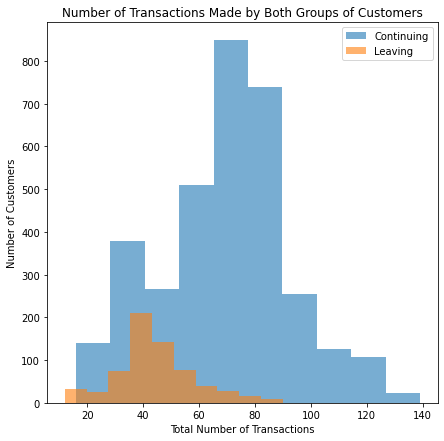

In [7]:
trainC = train[train['Attrition_Flag'] == 'Continuing']
trainL = train[train['Attrition_Flag'] == 'Leaving']

plt.figure(figsize = (7, 7))

plt.hist(trainC['Total_Trans_Ct'], alpha = 0.6, label = 'Continuing')
plt.hist(trainL['Total_Trans_Ct'], alpha = 0.6, label = 'Leaving')
plt.xlabel('Total Number of Transactions')
plt.ylabel('Number of Customers')
plt.title('Number of Transactions Made by Both Groups of Customers')
plt.legend(loc = 'upper right')

plt.show()

It is clear from the plot above that the customers that quit tended to make less transactions. Most customers that quit had made less than 50 transactions over the past 12 months.

Below, we introduce a simple classification rule and evaluate the performance of this rule on the training set. The rule is to predict that a customer will leave the credit card services if they made no more than 50 transactions over the past 12 months. If this simple rule performs relatively well, we will not need to use complex machine learning models to make predictions on our test set.

In [8]:
rule = train['Total_Trans_Ct'] <= 50
rule_based_preds = rule.replace([True, False], ['Leaving', 'Continuing'])

cm = confusion_matrix(train['Attrition_Flag'], rule_based_preds)

print('Performance of Rule-Based Classification on Training Set\n')
print('{:>21}{:>23}{:>20}{:>6}'.format('', 'Predicted "Continuing"', 'Predicted "Leaving"', 'Total'))
print('{:>21}{:>23}{:>20}{:>6}'.format('Actually "Continuing"', cm[0][0], cm[0][1], cm[0][0]+cm[0][1]))
print('{:>21}{:>23}{:>20}{:>6}'.format('Actually "Leaving"', cm[1][0], cm[1][1], cm[1][0]+cm[1][1]))
print('{:>21}{:>23}{:>20}{:>6}'.format('Total', cm[0][0]+cm[1][0], cm[0][1]+cm[1][1], cm[0][0]+cm[1][0]+cm[0][1]+cm[1][1]))

Performance of Rule-Based Classification on Training Set

                      Predicted "Continuing" Predicted "Leaving" Total
Actually "Continuing"                   2645                 749  3394
   Actually "Leaving"                    171                 485   656
                Total                   2816                1234  4050


We can see above that our simple classification rule correctly identified most customers that truly left the credit card services. However, it misclassified many customers that actually continued the credit card services. Therefore, this rule has relatively high recall and relatively low precision. Since we are not satisfied with the performance of this rule, we will consider more complex models.

The confusion matrix reveals that in the training set, there are many more customers that stayed with the credit card services than customers who left. Therefore, our training set is imbalanced, and we need to take this into account during the modeling process.

Below, we evaluate the cross validation performance of gradient boosting machines, tuning the number of trees hyperparameter. We are using gradient boosting machines because boosting handles class imbalance in the training set by increasing the weights of misclassified observations at each step.

In [9]:
gbm = H2OGradientBoostingEstimator(seed = 2021, nfolds = 10, fold_assignment = 'Stratified')
numtrees_gbm = {'ntrees': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]}
gbm_cv = H2OGridSearch(gbm, numtrees_gbm)
gbm_cv.train(x = train_h2o.columns[:-1], y = 'Attrition_Flag', training_frame = train_h2o)

gbm_cv_results = gbm_cv.get_grid(sort_by = 'f1', decreasing = True)
gbm_cv_results.sorted_metric_table()[['ntrees', 'f1']]

,ntrees,f1
0,140.0,0.917051
1,150.0,0.916031
2,130.0,0.914861
3,120.0,0.914329
4,100.0,0.913410
5,110.0,0.913043
6,90.0,0.911315
7,80.0,0.907407
8,70.0,0.907121
9,60.0,0.901779


We can see that having 140 trees in the gradient boosting machine leads to the highest cross validation F1 score, which is 0.917.

Going back to our scenario, the bank manager has decided to use a gradient boosting machine with 140 trees to predict whether each customer in the target city will quit being a customer or not. The manager trains this model on the dataset from last year's customers. Afterwards, the model reads in the dataset from customers in the target city, and uses its training to predict whether each customer in the dataset will leave the credit card services.

In [10]:
test_h2o = H2OFrame(test.drop('Attrition_Flag', axis = 1))

gbm_final = gbm_cv_results.models[0]
gbm_final_preds = gbm_final.predict(test_h2o)['predict'].as_data_frame()
gbm_final_preds.index = test.index

The bank's employees spend the next several days reaching out to each customer in the target city that is likely to leave the credit card services (based on what the model predicts) and trying to convince them to stay with their credit card services. The results of this campaign are below.

In [11]:
cm = confusion_matrix(test['Attrition_Flag'], gbm_final_preds)

print('Results\n')
print('{:>21}{:>23}{:>20}{:>6}'.format('', 'Predicted "Continuing"', 'Predicted "Leaving"', 'Total'))
print('{:>21}{:>23}{:>20}{:>6}'.format('Actually "Continuing"', cm[0][0], cm[0][1], cm[0][0]+cm[0][1]))
print('{:>21}{:>23}{:>20}{:>6}'.format('Actually "Leaving"', cm[1][0], cm[1][1], cm[1][0]+cm[1][1]))
print('{:>21}{:>23}{:>20}{:>6}'.format('Total', cm[0][0]+cm[1][0], cm[0][1]+cm[1][1], cm[0][0]+cm[1][0]+cm[0][1]+cm[1][1]))

Results

                      Predicted "Continuing" Predicted "Leaving" Total
Actually "Continuing"                   5038                  68  5106
   Actually "Leaving"                    125                 846   971
                Total                   5163                 914  6077


Of the 914 customers that the bank reached out to, 846 of them (92.6%) were actually about to quit. For simplicity's sake, we can assume that all of them decided to stay with the services after being contacted by the bank. Unfortunately, the bank failed to reach out to an additional 125 customers that were about to quit being customers. Overall, we were able to prevent 87.1% of likely-to-quit customers from leaving the credit card services.